In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [4]:
# Finding optimal shift for diff
def find_shift(series):
    best_pval = 1
    best_i = 0
    for i in range(1,36):
        t_s = series[i:] - series[:-i]
        cur_pval = adfuller(t_s)[1]
        if cur_pval < best_pval:
            best_pval = cur_pval
            best_i = i
    
    return best_pval, best_i

In [5]:
# Train dataset from Kaggle ASHRAE competition - meters for buildings
df = pd.read_csv('train.csv')

In [6]:
df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [8]:
df.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [9]:
series = df.query('building_id ==1 and meter==0')['meter_reading'].reset_index(drop=True)

In [10]:
# Adding small constant - else box-cox will fail
# series += 0.0001

In [11]:
len(series)

8784

In [12]:
# series = pd.read_csv("Series/international-airline-passengers.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                   -2.396413
p-value                           0.142751
#Lags Used                       33.000000
Number of Observations Used    8750.000000
Critical Value (1%)              -3.431098
Critical Value (5%)              -2.861870
Critical Value (10%)             -2.566946
dtype: float64


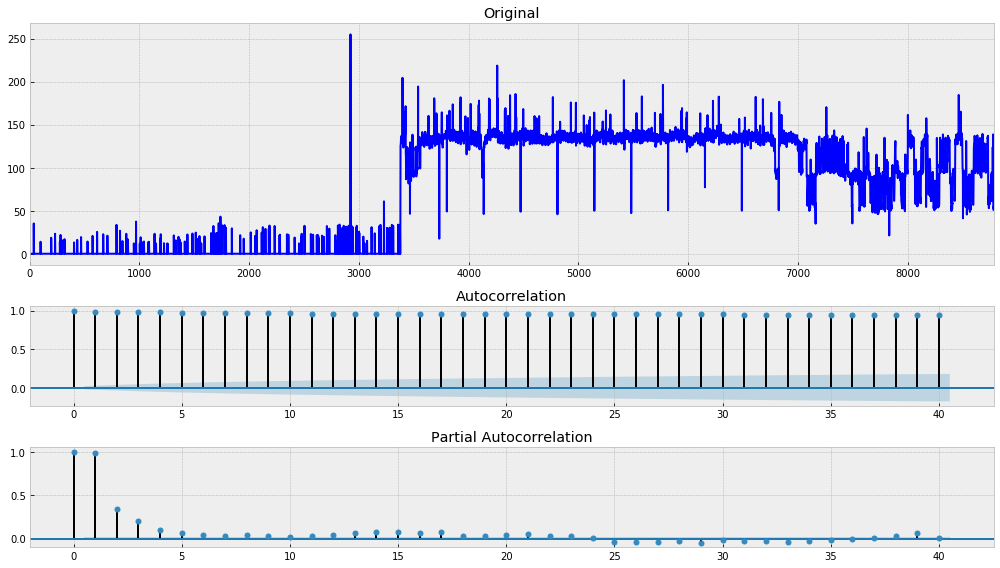

In [13]:
tsplot(series)

In [14]:
series = series.to_numpy()[1:] - series.to_numpy()[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.661543e+01
p-value                        1.716280e-29
#Lags Used                     3.700000e+01
Number of Observations Used    8.745000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


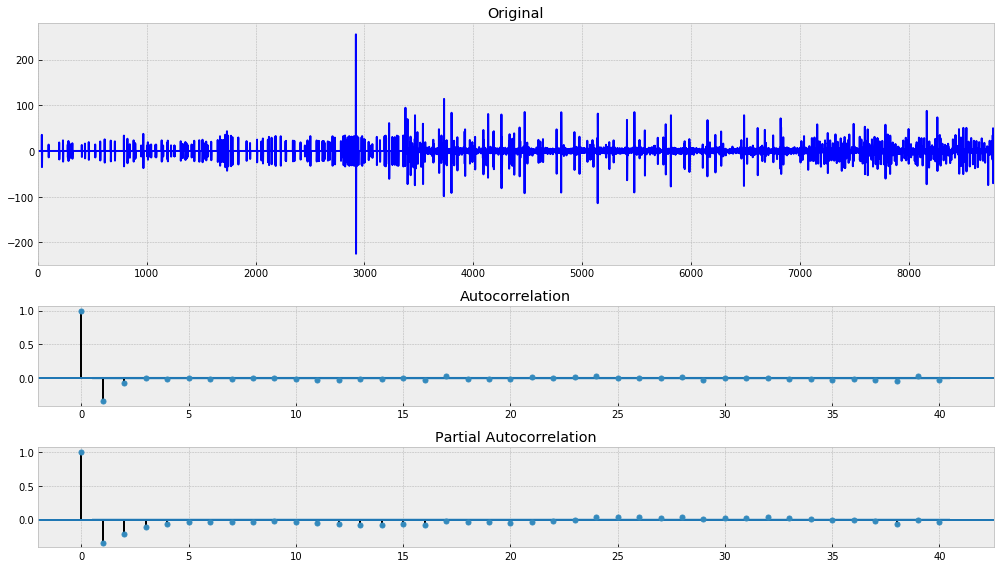

In [15]:
tsplot(series)

Как мы видим, и тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Ряд оказался неинтересным для анализа - простое дифференцирование делает его стационарным. Кроме этого, похоже, что у нас 3 разных ряда - 0-3500, 3500-7000, 7000+ (если что - число это кол-во часов с 1.01.2017)

In [16]:
# Let's try another bulding
series = df.query('building_id ==42 and meter==0')['meter_reading'].reset_index(drop=True)

In [17]:
series += 0.00001

Results of Dickey-Fuller Test:
Test Statistic                   -1.669489
p-value                           0.446897
#Lags Used                       37.000000
Number of Observations Used    8746.000000
Critical Value (1%)              -3.431098
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64


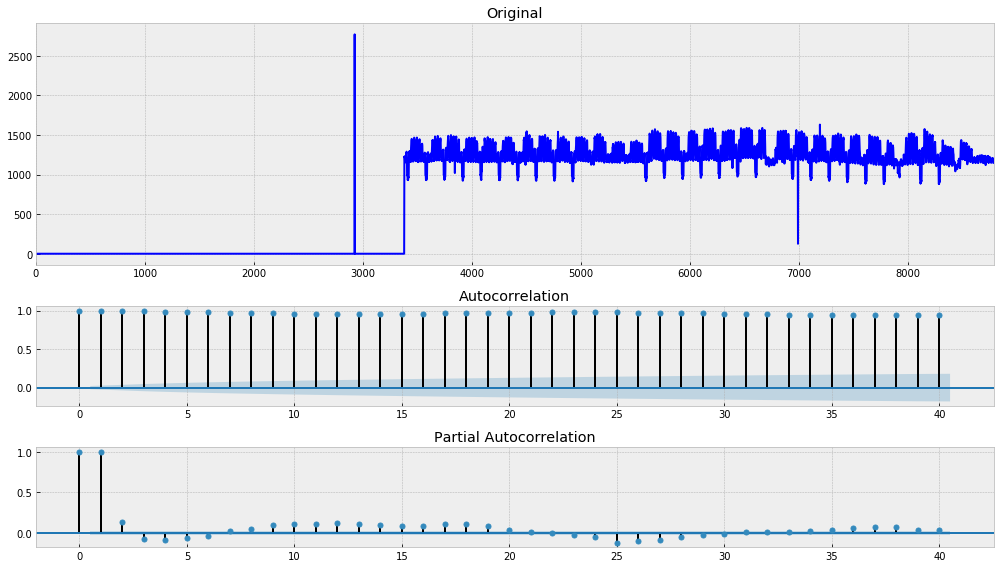

In [18]:
tsplot(series)

In [19]:
# Remove beginning - zeroes
series = series[3500:]

Results of Dickey-Fuller Test:
Test Statistic                -1.181833e+01
p-value                        8.532117e-22
#Lags Used                     3.300000e+01
Number of Observations Used    5.250000e+03
Critical Value (1%)           -3.431596e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


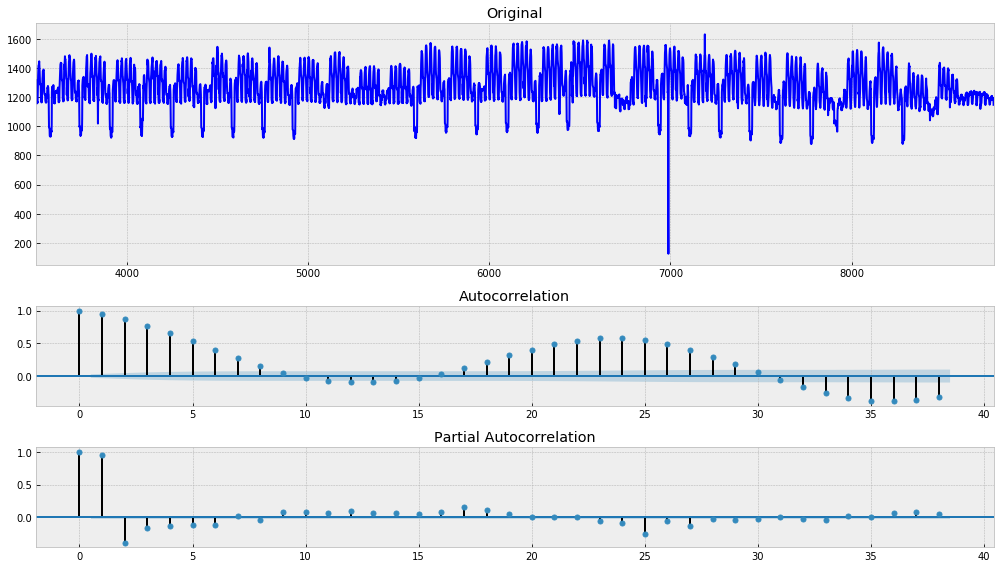

In [20]:
tsplot(series)

Уже интереснее. Тест Дики-Фуллера говорит о стационарности ряда, однако графики корреляции говорят об обратном - автокорреляция вместо быстрого убывания ходит по синусоиде. Тренда нет, дисперсия, похоже, примерно постоянная. Зато есть 2 сезона - день/ночь и недели (исходя из того, что это за данные :) ) Как выяснилось - дифференцирование по дням применять не надо

In [21]:
# Удаляем выброс
#Remove peak near 7000 - just 2 walues, fill with mean
t_s = series
counter = 0
s_mean = series.mean()
for i in series:
    if i < 800:
        t_s.replace(i, s_mean, inplace=True)
        counter += 1
        
series = t_s

In [22]:
# Day diff
# series = series.to_numpy()[24:] - series.to_numpy()[:-24]

In [23]:
# tsplot(series)

In [24]:
#week season
series = series.to_numpy()[168:] - series.to_numpy()[:-168]

Results of Dickey-Fuller Test:
Test Statistic                -8.678878e+00
p-value                        4.340395e-14
#Lags Used                     3.300000e+01
Number of Observations Used    5.082000e+03
Critical Value (1%)           -3.431637e+00
Critical Value (5%)           -2.862109e+00
Critical Value (10%)          -2.567073e+00
dtype: float64


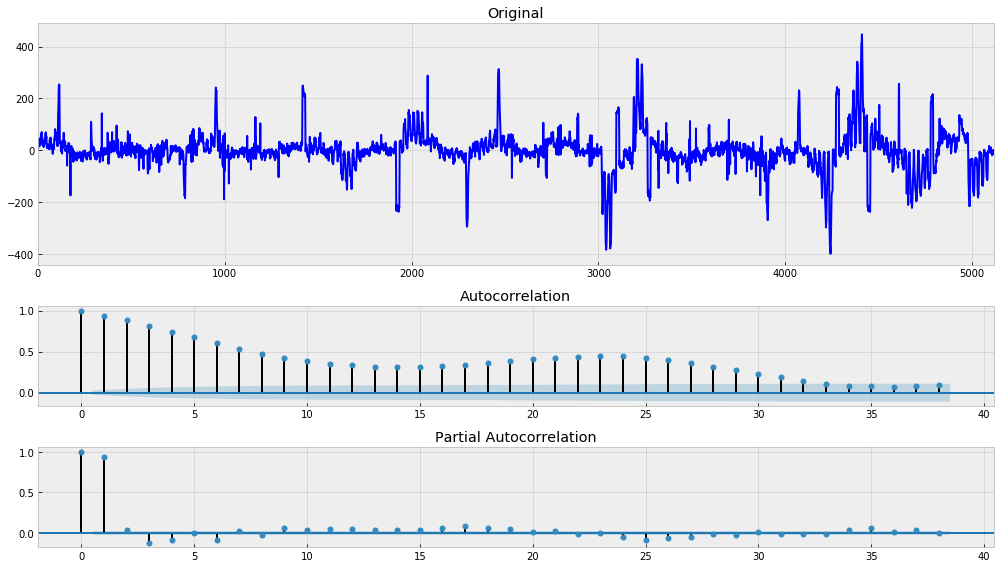

In [25]:
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.570453e+01
p-value                        1.383107e-28
#Lags Used                     3.300000e+01
Number of Observations Used    5.081000e+03
Critical Value (1%)           -3.431638e+00
Critical Value (5%)           -2.862109e+00
Critical Value (10%)          -2.567073e+00
dtype: float64


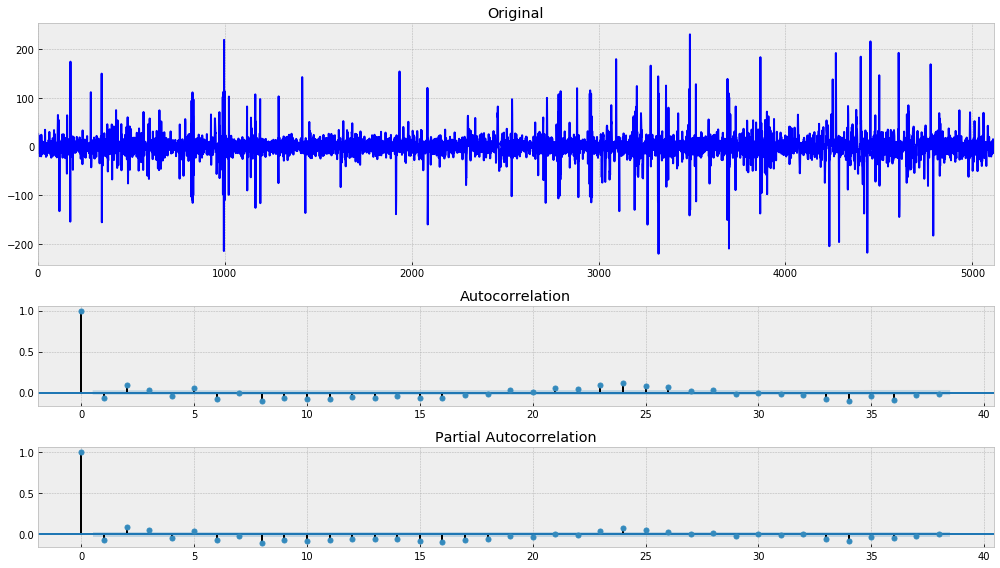

In [26]:
t_s = series[1:] - series[:-1]
# t_s = boxcox(t_s, 0)
# t_s += 500
tsplot(t_s)

Помогло дифференцирование по неделям и потом просто дифференциал. Непонятно, почему период дня не нужен....

# Female birth

In [27]:
df = pd.read_csv('Series/daily-total-female-births-in-cal.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
Date     365 non-null object
Count    365 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [29]:
df.head()

,Date,Count
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [30]:
series = df['Count']

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


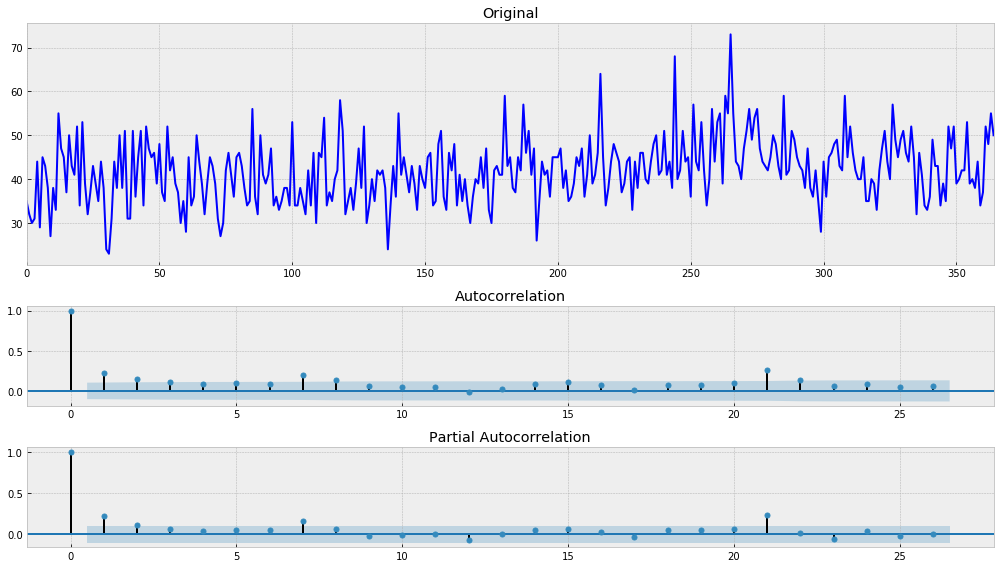

In [31]:
tsplot(series)

# ИМХО, ряд стационарный сам по себе ))

# Dow Jones CLosing

In [32]:
df = pd.read_csv('Series/weekly-closings-of-the-dowjones-.csv')

In [33]:
df.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [34]:
series = df.Close

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


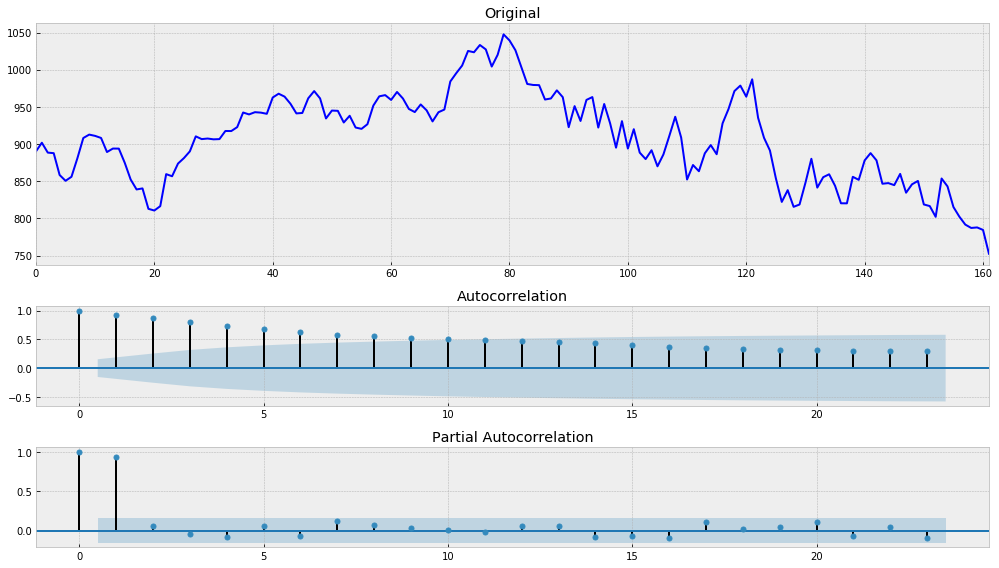

In [35]:
tsplot(series)

In [36]:
t_s = series.to_numpy()[1:] - series.to_numpy()[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


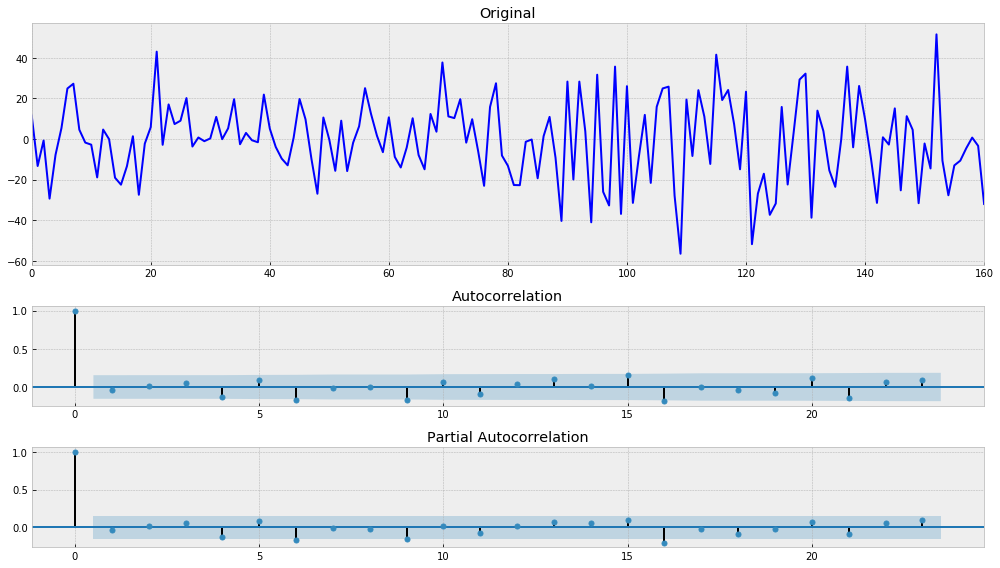

In [37]:
tsplot(t_s)

# простое дифференцирование сделало ряд стационарным

# Monthly sales

In [38]:
df = pd.read_csv('Series/monthly-sales-of-company-x-jan-6.csv')

In [39]:
df.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
Month    77 non-null object
Count    77 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


In [41]:
series = df.Count

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


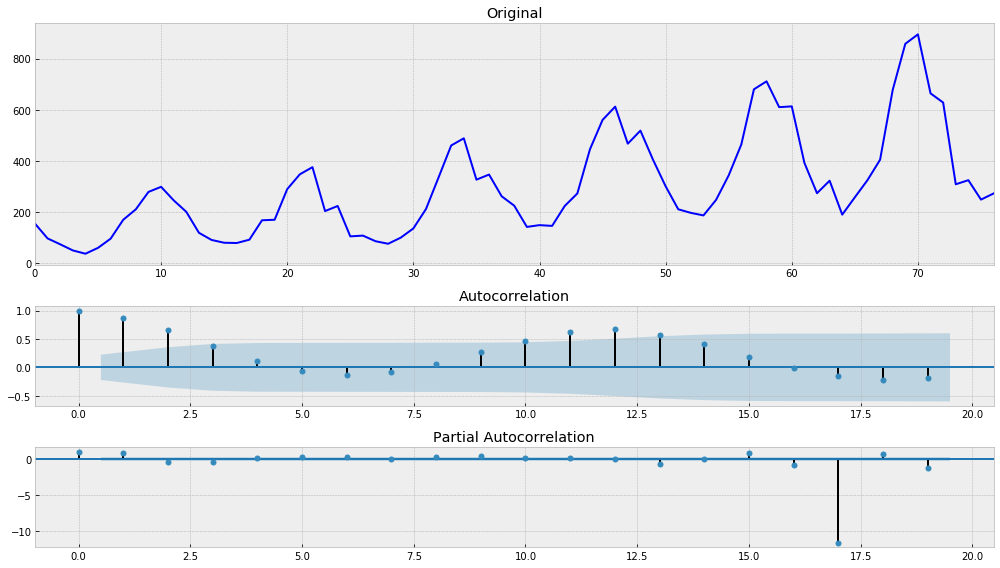

In [42]:
tsplot(series)

In [43]:
# Дисперсия растет - применяем Бокса-Кокса
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


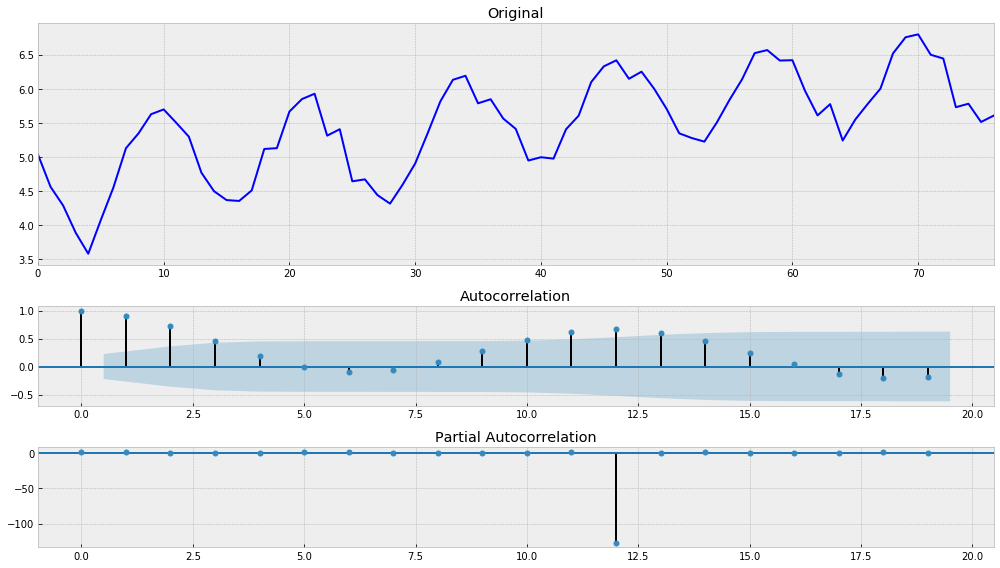

In [44]:
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                 -2.385128
p-value                         0.145978
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


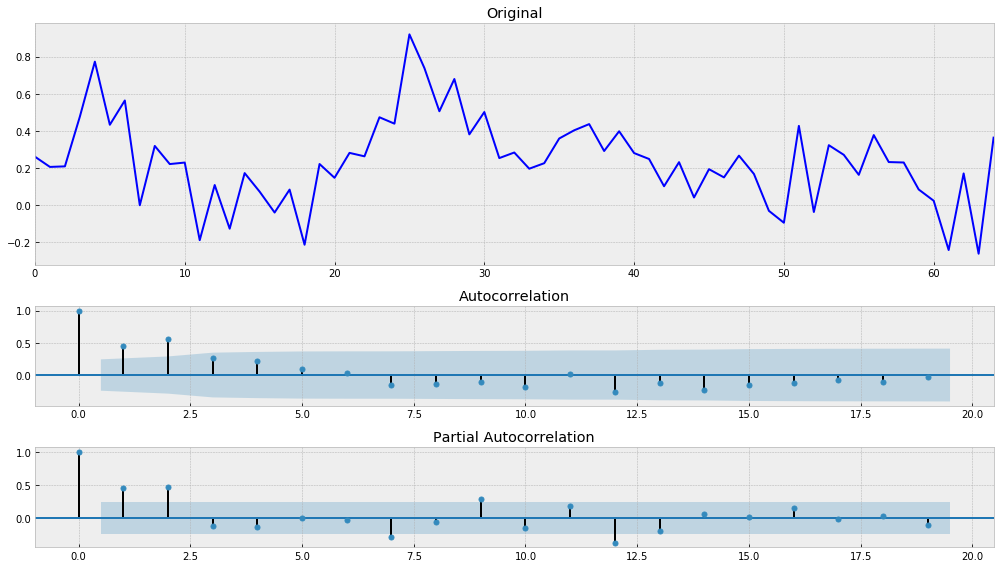

In [45]:
# Есть тренд - дифференцируем с шагом ноль, кроме того, есть сезонность - дифференцируем с шагом 12
t_s = series[1:] - series[:-1]
t_s = series[12:] - series[:-12]
tsplot(t_s)

Ничего путного не получилось... попробуем подобрать 

In [46]:
# one more diff for t_s
find_shift(t_s)

(0.0011019182026669931, 4)

Results of Dickey-Fuller Test:
Test Statistic                 -4.065956
p-value                         0.001102
#Lags Used                     11.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


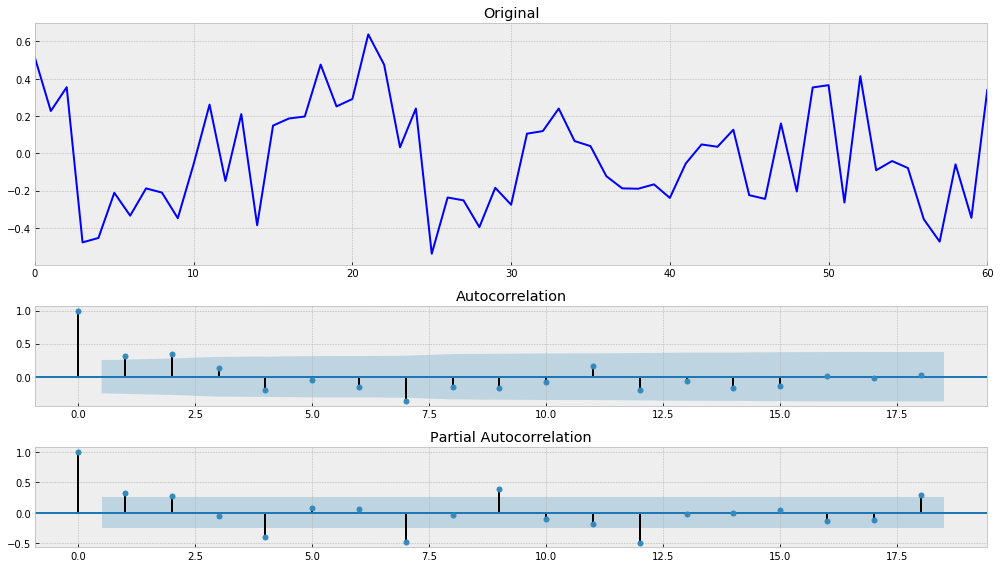

In [47]:
tt_s = t_s[4:] - t_s[:-4]
tsplot(tt_s)

В итоге, после трех дифференцирований с шагом 1, 12, 4 ряд можно назавть стационарным.

In [48]:
df = pd.read_csv('Series/monthly-boston-armed-robberies-j.csv')

In [49]:
df.head()

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [50]:
series = df.Count

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


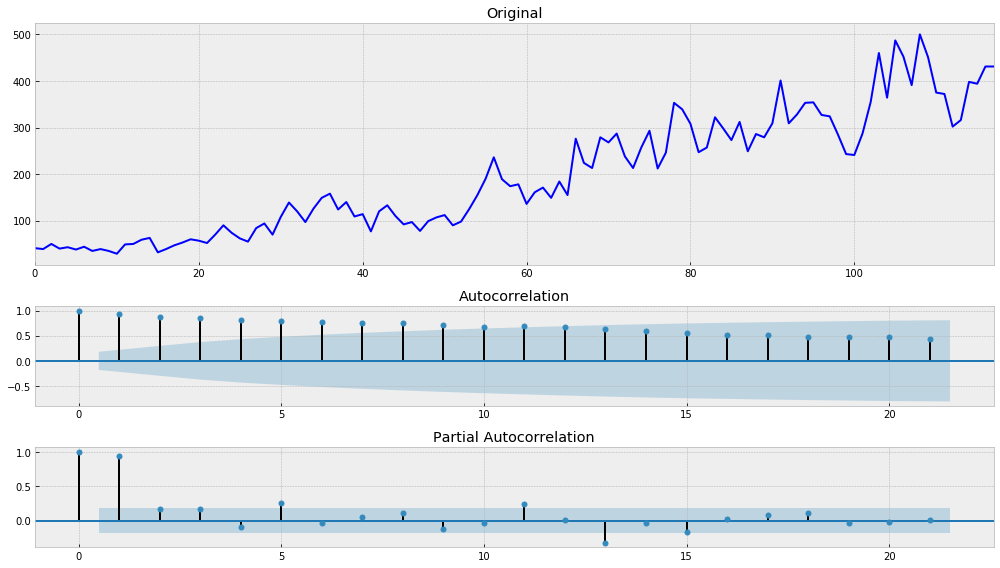

In [51]:
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


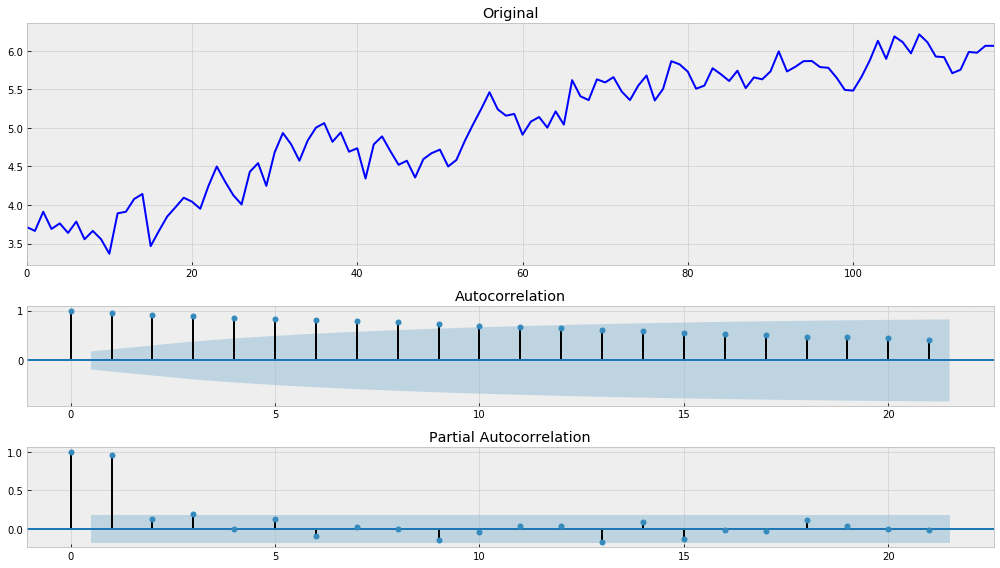

In [52]:
#убираем дисперсию
series = boxcox(series, 0)
tsplot(series)

In [53]:
find_shift(series)

(2.3786024417438203e-11, 1)

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


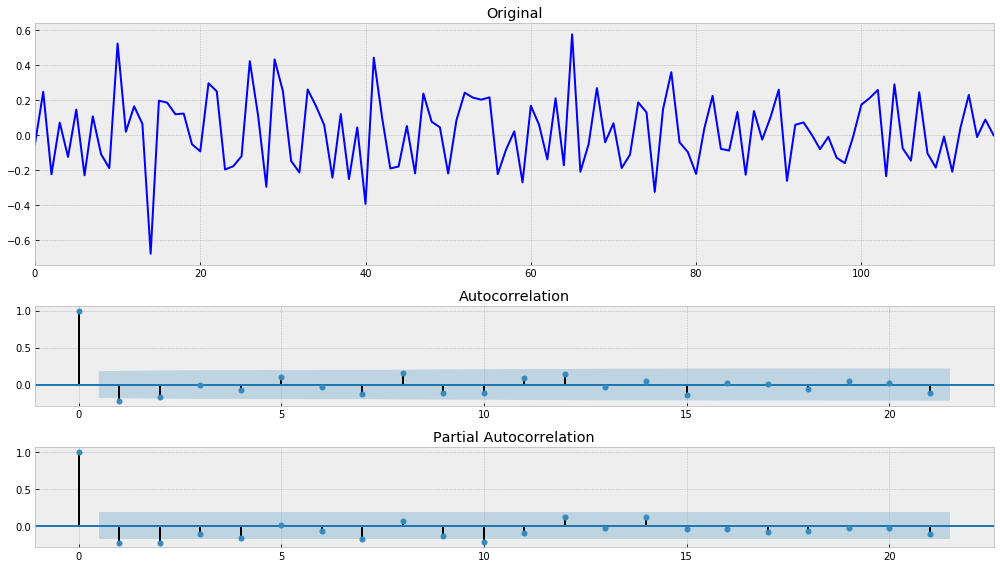

In [54]:
t_s = series[1:] - series[:-1]
tsplot(t_s)

Преобразование Бокса-Кокса и дифференциал делают грабителей послушными.